In [30]:
from pathlib import Path

import cv2
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import torch.utils.data as data
import os

from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
df.columns

In [ ]:
df = pd.read_csv("../input/birdsong-recognition/train_32000.csv")

In [ ]:
p2c = {p:c for c ,p in zip(df.ebird_code.values, df.primary_label.values)}

In [ ]:
p2c

In [ ]:
len(p2c.keys())

In [ ]:
len(list(set(p2c.values())))

In [ ]:
p2c

In [ ]:
df.secondary_labels[0].replace('[', '').replace(']', '').replace("\'", '').split(",")

In [ ]:
non_labels = []
sls_log = []
for sls in df.secondary_labels:
    sls_2 = []
    for sl in sls.replace('[', '').replace(']', '').replace("\'", '').replace("\"", '').split(","):
        if sl == "":
            continue
        if sl[0] == " ":
            sl = sl[1:]
        if sl[-1] == " ":
            sl = sl[:-1]
        try:
#             print(p2c[sl])
#             sls_log.append(p2c[sl])
            sls_2.append(p2c[sl])
        except:
            non_labels.append(sl)
    sls_log.append(sls_2)
#     print(sls_2)

In [ ]:
labels_all = []
for i, label in enumerate(df.ebird_code.values):
    labels = [label]
    labels.extend(sls_log[i])
    labels_all.append(labels)

In [ ]:
labels_all

In [ ]:
len(set(non_labels))

In [ ]:
idx = ys.argsort()[2]
PERIOD = 6
sample = df.loc[idx, :]
wav_name = sample["resampled_filename"]
ebird_code = sample["ebird_code"]
y, sr = sf.read(os.path.join("../input/train_audio_resampled_32000/",  ebird_code ,  wav_name))

In [ ]:
len_y = len(y)
print(f"len_y {len_y}")
effective_length = sr * PERIOD
if len_y < effective_length:
    new_y = np.zeros(effective_length, dtype=y.dtype)
    start = np.random.randint(effective_length - len_y)
    new_y[start:start + len_y] = y
    y_crop = new_y.astype(np.float32)
elif len_y > effective_length:
    start = np.random.randint(len_y - effective_length)
    y_crop = y[start:start + effective_length].astype(np.float32)
else:
    y_crop = y.astype(np.float32)
print(f"start position {start}, len {len(y_crop)}")
melspec = librosa.feature.melspectrogram(y_crop, sr=sr, **{})
melspec = librosa.power_to_db(melspec).astype(np.float32)
print(f"melspec size {melspec.shape}")
plt.axis('off')
plt.imshow(melspec)

In [ ]:
len_y = len(y)
print(f"len_y {len_y}")
pad = 1000
effective_length = sr * PERIOD
y_crop = np.tile(y[pad :-pad ], (effective_length // (len_y-pad *2) + 1,))
start = np.random.randint(len(y_crop) - effective_length)
y_crop = y_crop[start:start + effective_length].astype(np.float32)
print(f"start position {start}, len {len(y_crop)}")
melspec = librosa.feature.melspectrogram(y_crop, sr=sr, **{})
melspec = librosa.power_to_db(melspec).astype(np.float32)
print(f"melspec size {melspec.shape}")
plt.axis('off')
plt.imshow(melspec)

In [ ]:
print(f"min length {min(ys)} max length {max(ys)} mean length {sum(ys) / len(ys)}")

In [42]:
train_df = pd.read_csv("../logs/resnest50f_bcekd_v2/fold0/logs/train_log.csv")
valid_df = pd.read_csv("../logs/resnest50f_bcekd_v2/fold0/logs/valid_log.csv")
train_df2 = pd.read_csv("../logs/resnest50f_bcekd_v3/fold0/logs/train_log.csv")
valid_df2 = pd.read_csv("../logs/resnest50f_bcekd_v3/fold0/logs/valid_log.csv")

In [43]:
import seaborn as sns

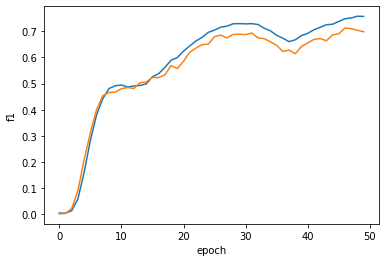

In [44]:
sns.lineplot(x="epoch", y="f1", data=train_df)
sns.lineplot(x="epoch", y="f1", data=valid_df)

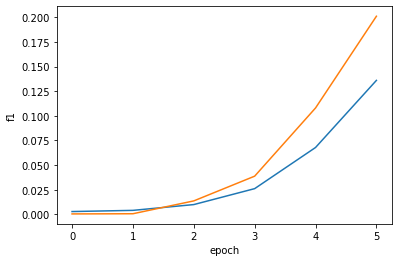

In [45]:
sns.lineplot(x="epoch", y="f1", data=train_df2)
sns.lineplot(x="epoch", y="f1", data=valid_df2)

In [9]:
!ls ../logs/resnest50f_bcekd_mixup/fold0/logs/train_log.csv

../logs/resnest50f_bcekd_mixup/fold0/logs/train_log.csv


In [11]:
train_df

,epoch,lr,loss,f1
0,0,9.755285e-04,0.034761,0.003338
1,1,9.045095e-04,0.024396,0.009207
2,2,7.938947e-04,0.021790,0.049012
3,3,6.545120e-04,0.018911,0.143195
4,4,5.000050e-04,0.016375,0.272170
5,5,3.454980e-04,0.014605,0.365747
6,6,2.061153e-04,0.013326,0.441738
7,7,9.550055e-05,0.012515,0.492631
8,8,2.448150e-05,0.012089,0.519948
9,9,1.000000e-08,0.011877,0.525781
